In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import os
import numpy as np
import pickle
from torchvision import transforms  # import PyTorch's module for image transforms
import torchvision.transforms.functional as TF  # import PyTorch's module for functional image transforms
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
import os
from tqdm import tqdm

**Configuration and Model Initialization**: In this block, we import the CharNet model and the cfg configuration from the CharNet package. We merge the configuration from a YAML file (icdar2015_hourglass88.yaml), freeze it to prevent further modifications, and print the configuration. Then, we initialize the CharNet model, load its pretrained weights from a file (icdar2015_hourglass88.pth), set it to evaluation mode, and move it to the CUDA device (if available).

In [4]:
from charnet.modeling.model import CharNet
from charnet.config import cfg

In [5]:
cfg.merge_from_file('configs/icdar2015_hourglass88.yaml')
cfg.freeze()
print(cfg)

CHAR_DICT_FILE: datasets/ICDAR2015/test/char_dict.txt
CHAR_MIN_SCORE: 0.25
CHAR_NMS_IOU_THRESH: 0.3
CHAR_STRIDE: 4
INPUT_SIZE: 2280
MAGNITUDE_THRESH: 0.2
NUM_CHAR_CLASSES: 68
RESULTS_SEPARATOR: ,
SIZE_DIVISIBILITY: 128
WEIGHT: weights/icdar2015_hourglass88.pth
WORD_DETECTOR_DILATION: 1
WORD_LEXICON_PATH: datasets/ICDAR2015/test/GenericVocabulary.txt
WORD_MIN_SCORE: 0.95
WORD_NMS_IOU_THRESH: 0.15
WORD_STRIDE: 4


In [6]:
model = CharNet()
model.load_state_dict(torch.load('icdar2015_hourglass88.pth'))
model.eval()
model.cuda()

CharNet(
  (backbone): HourGlassNet(
    (pre): Sequential(
      (0): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Residual(
        (conv_1): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv_2): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (skip): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
       

**Image Resizing and Visualization**: In this block, we define two functions. The **resize** function resizes the input image while maintaining its aspect ratio and calculates the scaling factors. The **vis** function visualizes the word instances by drawing bounding boxes and text annotations on the image. We load an image (sample.jpg), resize it using the resize function, and pass it through the model to obtain the character bounding boxes (char_bboxes), character scores (char_scores), and word instances (word_instances). We then visualize the word instances on the original image using the vis function and display the resulting image.

In [7]:
def resize(im, size):
    h, w, _ = im.shape
    scale = max(h, w) / float(size)
    image_resize_height = int(round(h / scale / cfg.SIZE_DIVISIBILITY) * cfg.SIZE_DIVISIBILITY)
    image_resize_width = int(round(w / scale / cfg.SIZE_DIVISIBILITY) * cfg.SIZE_DIVISIBILITY)
    scale_h = float(h) / image_resize_height
    scale_w = float(w) / image_resize_width
    im = cv2.resize(im, (image_resize_width, image_resize_height), interpolation=cv2.INTER_LINEAR)
    return im, scale_w, scale_h, w, h

In [8]:
def vis(img, word_instances):
    img_word_ins = img.copy()
    for word_ins in word_instances:
        word_bbox = word_ins.word_bbox
        cv2.polylines(img_word_ins, [word_bbox[:8].reshape((-1, 2)).astype(np.int32)], True, (0, 255, 0), 2)
        cv2.putText(
            img_word_ins,
            '{}'.format(word_ins.text),
            (int(word_bbox[0]), int(word_bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1
        )
    return img_word_ins

In [9]:
im_original = cv2.imread('sample.jpg')
im, scale_w, scale_h, original_w, original_h = resize(im_original, size=cfg.INPUT_SIZE)
with torch.no_grad():
    char_bboxes, char_scores, word_instances = model(im, scale_w, scale_h, original_w, original_h)

In [10]:
img = vis(im_original, word_instances)

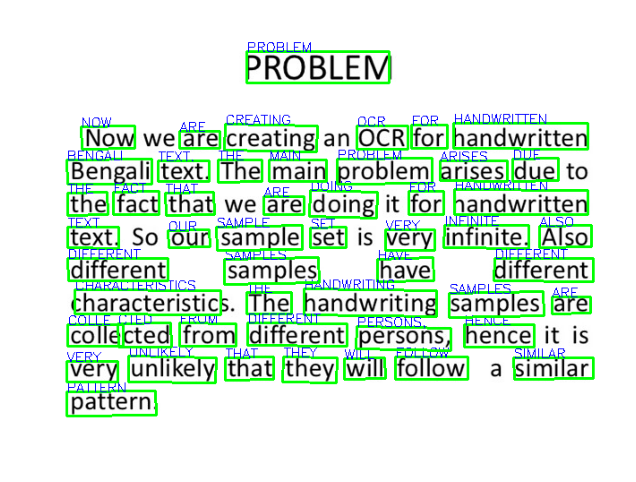

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:
word_instances[0].word_bbox

array([410., 278., 472., 276., 473., 302., 410., 303.], dtype=float32)

In [13]:
word_instances[0].text

'HAVE'

**Ground Truth Reading and Evaluation**: In this block, we define the read_gt function, which reads the ground truth annotations from a file and returns them in a specific format. We specify the directories for image files and ground truth files (img_dir and gts_dir). We use the glob function to obtain the paths of all image and ground truth files.

In [14]:
def read_gt(gt_path):
    lines = open(gt_path, encoding="utf-8").readlines()
    single_img_bboxes = []
    for line in lines:
        box_info_dict = {"points": None, "text": None, "ignore": None}

        box_info = line.strip().encode("utf-8").decode("utf-8-sig").split(",")
        box_points = [int(box_info[j]) for j in range(8)]
        word = box_info[8:]
        word = ",".join(word)
        box_points = np.array(box_points, np.int32).reshape(4, 2)

        box_info_dict["points"] = box_points
        box_info_dict["text"] = word
        if word == "###":
            box_info_dict["ignore"] = True
        else:
            box_info_dict["ignore"] = False

        single_img_bboxes.append(box_info_dict)
    return single_img_bboxes

In [15]:
img_dir = 'ocr/icdar2015/test_images'
gts_dir = 'ocr/icdar2015/test_gts'

In [16]:
img_files = natsorted(glob(os.path.join(img_dir, '*.jpg')))
gts_files = natsorted(glob(os.path.join(gts_dir, '*.txt')))

We import the DetectionIoUEvaluator class from the iou module and create an instance of it (evaluator).

In [17]:
from iou import DetectionIoUEvaluator

In [18]:
evaluator = DetectionIoUEvaluator()

In [19]:
len(img_files), len(gts_files)

(500, 500)

In [20]:
gt_path = gts_files[0]

In [21]:
lines = open(gt_path, encoding="utf-8").readlines()

In [22]:
lines

['933,255,954,255,956,277,936,277,###\n',
 '172,323,195,324,195,339,177,339,###\n',
 '83,270,118,271,115,294,88,291,###\n',
 '940,310,962,310,962,320,940,320,###\n',
 '946,356,976,351,978,368,950,374,###\n',
 '940,322,962,322,964,333,943,334,###\n',
 '128,344,210,342,206,361,128,362,###\n',
 '312,303,360,303,360,312,312,312,###\n']

We iterate over the image and ground truth files, load each image, resize it, pass it through the model to obtain word instances, process the word instances to create predictions, read the ground truth annotations, and evaluate the predictions using the evaluate_image method of the evaluator. The evaluation results are stored in a list (results). Finally, we combine the results using the combine_results method of the evaluator and print the metrics.

In [23]:
results = []
for i in tqdm(range(len(gts_files))):
    img_path, gts_path = img_files[i], gts_files[i]
    im_original = cv2.imread(img_path)
    im, scale_w, scale_h, original_w, original_h = resize(im_original, size=cfg.INPUT_SIZE)
    with torch.no_grad():
        char_bboxes, char_scores, word_instances = model(im, scale_w, scale_h, original_w, original_h)
    pred = []
    for word_ins in word_instances:
        if len(word_ins.text) > 0:
            box_points = np.array(word_ins.word_bbox, np.int32).reshape(4, 2)
            word = word_ins.text
            box_info_dict = {"points" : box_points,
                             "text" : word,
                             "ignore": False}
            pred.append(box_info_dict)

    gt = read_gt(gts_path)
    
    results.append(evaluator.evaluate_image(gt, pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:07<00:00,  1.58s/it]


In [24]:
metrics = evaluator.combine_results(results)
print(metrics)

{'precision': 0.96625, 'recall': 0.7443428021184401, 'hmean': 0.8409029099809626}
